# Finetuning Segment Anything (SAM)

Here is an example for finetuning SAM on image data and respective segmentations from the Cell Tracking Challenge (DIC-C2DH-HeLa: HeLa cells on a flat glass - https://doi.org/10.1038/s41592-023-01879-y)

### Let's check, where are you now?

**NOTE**: The scripts have been tested on our recommended open-source cloud servers, [Kaggle Notebooks](https://www.kaggle.com/code/).

In [1]:
import os
current_spot = os.getcwd()

if current_spot.startswith("/kaggle/working"):
    using_kaggle = True
    print("Kaggle says hi!")
    root_dir = "/kaggle/working"

else:
    if current_spot.startswith("/content"):
        using_colab = True
        print("Google Colab says hi!")
        print(" NOTE: The scripts have not been tested on Google Colab, you might need to adapt the installations a bit.")
        root_dir = "/content"

        # You might need to install condacolab on Google Colab to be able to install packages using conda / mamba
        # !pip install -q condacolab
        # import condacolab
        # condacolab.install()
    
    else:
        msg = "You are using a behind-the-scenes resource. Follow our installation instructions here:"
        msg += " https://computational-cell-analytics.github.io/micro-sam/micro_sam.html#installation"
        print(msg)
        root_dir = ""  # overwrite to set the root directory, where the data, checkpoints, and all relevant stuff will be stored

You are using a behind-the-scenes resource. Follow our installation instructions here: https://computational-cell-analytics.github.io/micro-sam/micro_sam.html#installation


## Installation

Let's install all the relevant dependencies required for training.

In [2]:
!git clone --quiet https://github.com/computational-cell-analytics/micro-sam.git
tmp_dir = os.path.join(root_dir, "micro-sam")
!pip install --quiet $tmp_dir

fatal: destination path 'micro-sam' already exists and is not an empty directory.


In [3]:
!git clone --quiet https://github.com/constantinpape/torch-em.git
tmp_dir = os.path.join(root_dir, "torch-em")
!pip install --quiet $tmp_dir

fatal: destination path 'torch-em' already exists and is not an empty directory.


In [4]:
!git clone --quiet https://github.com/constantinpape/elf.git
tmp_dir = os.path.join(root_dir, "elf")
!pip install --quiet $tmp_dir

fatal: destination path 'elf' already exists and is not an empty directory.


In [5]:
!mamba install -q -y -c conda-forge nifty affogato zarr z5py
!pip uninstall -y --quiet qtpy  # qtpy is not supported in Kaggle / Google Colab, let's remove it to avoid errors.

### Importing the libraries

In [6]:
from glob import glob
from IPython.display import FileLink

import numpy as np
import imageio.v3 as imageio
from matplotlib import pyplot as plt

import torch

import torch_em
from torch_em.model import UNETR
from torch_em.util.debug import check_loader
from torch_em.loss import DiceBasedDistanceLoss
from torch_em.transform.label import PerObjectDistanceTransform

from micro_sam import util
import micro_sam.training as sam_training
from micro_sam.sample_data import fetch_tracking_example_data, fetch_tracking_segmentation_data
from micro_sam.instance_segmentation import (
    InstanceSegmentationWithDecoder,
    get_predictor_and_decoder,
    mask_data_to_segmentation
)

/home/anwai/mambaforge/envs/sam/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Let's download the dataset

In [7]:
DATA_FOLDER = os.path.join(root_dir, "data")
os.makedirs(DATA_FOLDER, exist_ok=True)

# This will download the image and segmentation data for training.
image_dir = fetch_tracking_example_data(DATA_FOLDER)
segmentation_dir = fetch_tracking_segmentation_data(DATA_FOLDER)

Example data directory is: /home/anwai/micro-sam/notebooks/data


### Let's create the dataloaders

Our task is to segment HeLa cells on a flat glass in DIC microscopic images. The dataset comes from https://celltrackingchallenge.net/2d-datasets/, and the dataloader has been implemented in [torch-em](https://github.com/constantinpape/torch-em/blob/main/torch_em/data/datasets/ctc.py).

#### First, let's visualize how our samples look.

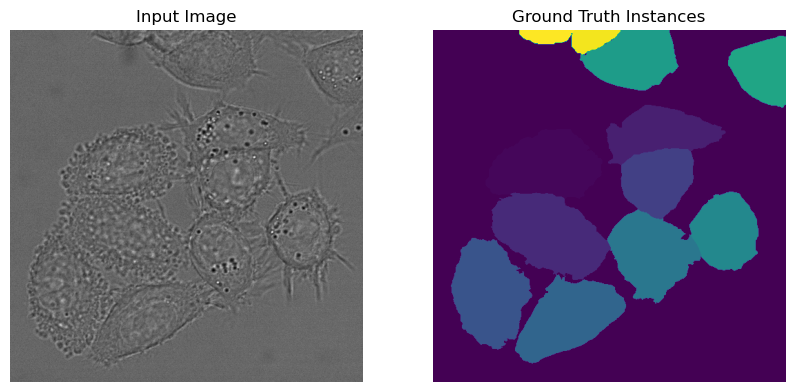

In [8]:
image_paths = sorted(glob(os.path.join(image_dir, "*")))
segmentation_paths = sorted(glob(os.path.join(segmentation_dir, "*")))

for image_path, segmentation_path in zip(image_paths, segmentation_paths):
    image = imageio.imread(image_path)
    segmentation = imageio.imread(segmentation_path)

    fig, ax = plt.subplots(1, 2, figsize=(10, 10))
    ax[0].imshow(image, cmap="gray")
    ax[0].set_title("Input Image")
    ax[0].axis("off")
    
    ax[1].imshow(segmentation)
    ax[1].set_title("Ground Truth Instances")
    ax[1].axis("off")
    
    plt.show()
    plt.close()
    
    break  # comment this out in case you want to visualize all the images

#### Next, let's create the dataloaders

In [9]:
# torch_em.default_segmentation_loader is a convenience function to build a torch dataloader
# from image data and labels for training segmentation models.
# It supports image data in various formats. Here, we load image data and labels from the two
# folders with tif images that were downloaded by the example data functionality, by specifying
# `raw_key` and `label_key` as `*.tif`. This means all images in the respective folders that end with
# .tif will be loadded.
# The function supports many other file formats. For example, if you have tif stacks with multiple slices
# instead of multiple tif images in a foldder, then you can pass raw_key=label_key=None.
# For more information, here is the documentation: https://github.com/constantinpape/torch-em/blob/main/torch_em/data/datasets/README.md

# Load images from multiple files in folder via pattern (here: all tif files)
raw_key, label_key = "*.tif", "*.tif"

# Alternative: if you have tif stacks you can just set raw_key and label_key to None
# raw_key, label_key= None, None

# The 'roi' argument can be used to subselect parts of the data.
# Here, we use it to select the first 70 images (frames) for the train split and the other frames for the val split.
train_roi = np.s_[:70, :, :]
val_roi = np.s_[70:, :, :]

#### Label Transform

The idea here is to convert the ground-truth to the desired instance for finetuning Segment Anything, and in addition if desired, to learn the foreground and distances to the object centers and object boundaries.

In [10]:
class LabelTransform:
    def __init__(self, train_instance_segmentation):
        self.train_instance_segmentation = train_instance_segmentation
        
    def __call__(self, labels):
        if self.train_instance_segmentation:
            # Computes the distance transform for objects to jointly perform the additional decoder-based automatic instance segmentation (AIS) and finetune Segment Anything.
            label_transform = PerObjectDistanceTransform(
                distances=True,
                boundary_distances=True,
                directed_distances=False,
                foreground=True,
                instances=True,
                min_size=25
            )
        else:
            # Ensures the individual object instances.to finetune the clasiscal Segment Anything.
            label_transform = torch_em.transform.label.connected_components

        labels = label_transform(labels)
        return labels

In [11]:
# The script below returns the train or val data loader for finetuning SAM.

# The data loader must be a torch data loader that returns `x, y` tensors,
# where `x` is the image data and `y` are the labels.
# The labels have to be in a label mask instance segmentation format.
# i.e. a tensor of the same spatial shape as `x`, with each object mask having its own ID.
# Important: the ID 0 is reseved for background, and the IDs must be consecutive

# Here, we use `torch_em.default_segmentation_loader` for creating a suitable data loader from
# the example hela data. You can either adapt this for your own data or write a suitable torch dataloader yourself.
# Here's a quickstart notebook to create your own dataloaders: https://github.com/constantinpape/torch-em/blob/main/notebooks/tutorial_create_dataloaders.ipynb

batch_size = 1  # the training batch size
patch_shape = (1, 512, 512)  # the size of patches for training

# Train an additional convolutional decoder for end-to-end automatic instance segmentation
train_instance_segmentation = True

label_transform = LabelTransform(train_instance_segmentation)

train_loader = torch_em.default_segmentation_loader(
    raw_paths=image_dir,
    raw_key=raw_key,
    label_paths=segmentation_dir,
    label_key=label_key,
    patch_shape=patch_shape,
    batch_size=batch_size,
    ndim=2,
    is_seg_dataset=True,
    rois=train_roi,
    label_transform=label_transform,
    shuffle=True,
    raw_transform=sam_training.identity,
)
val_loader = torch_em.default_segmentation_loader(
    raw_paths=image_dir,
    raw_key=raw_key,
    label_paths=segmentation_dir,
    label_key=label_key,
    patch_shape=patch_shape,
    batch_size=batch_size,
    ndim=2,
    is_seg_dataset=True,
    rois=val_roi,
    label_transform=label_transform,
    shuffle=True,
    raw_transform=sam_training.identity,
)

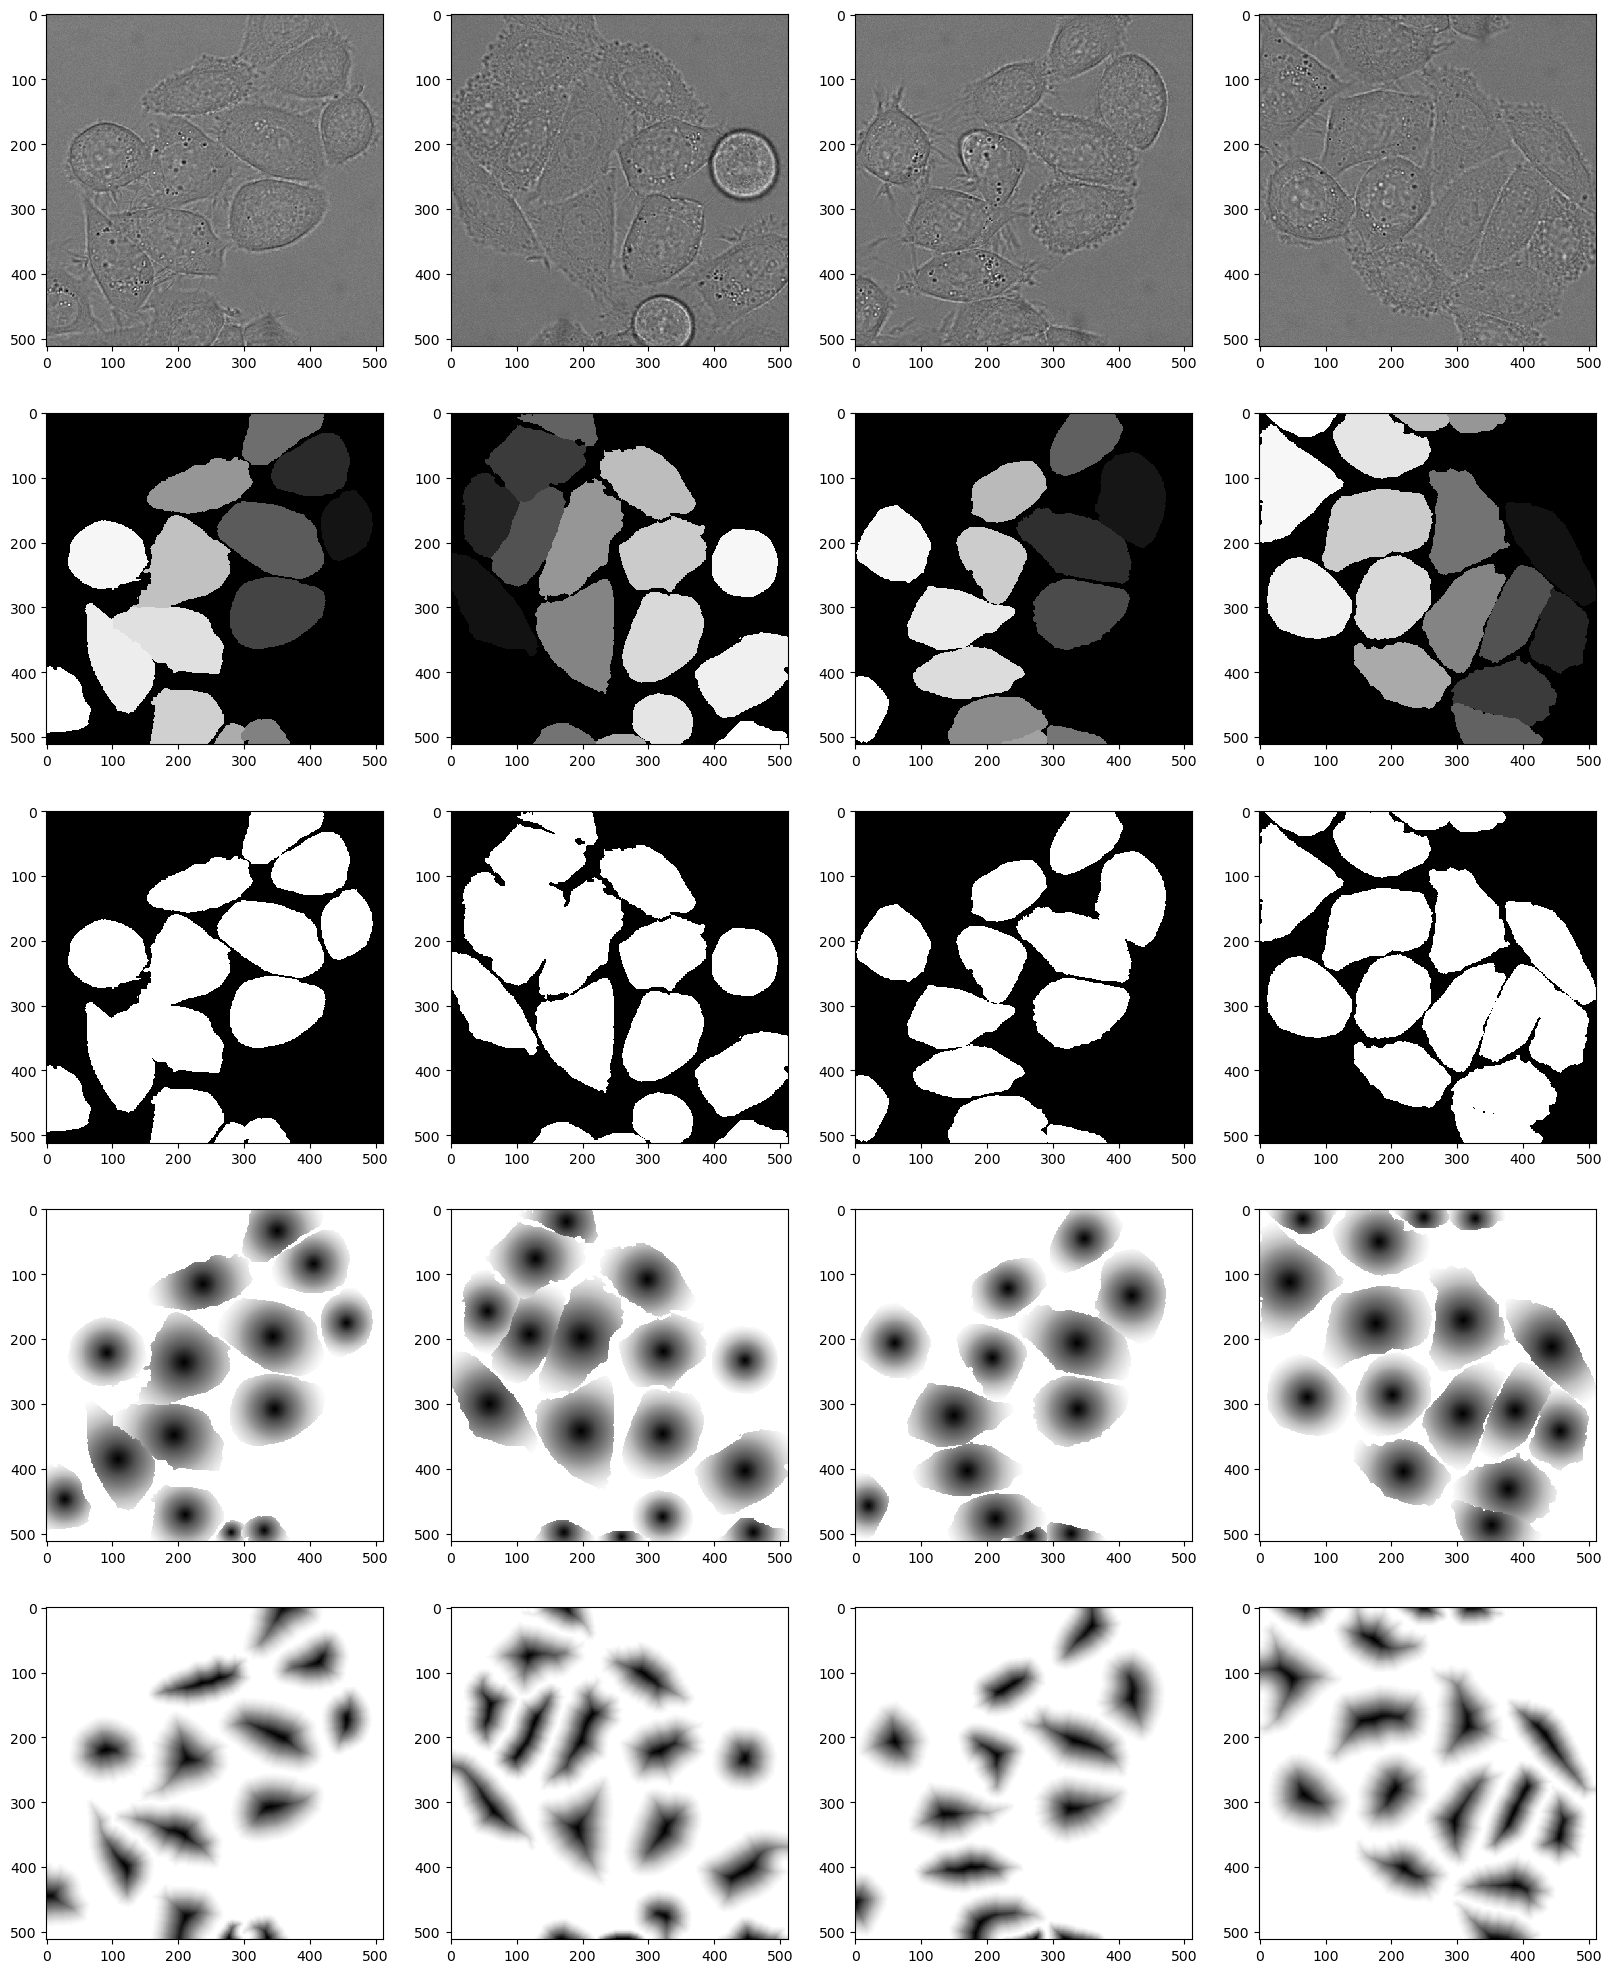

In [12]:
# Let's check how our samples look from the dataloader
check_loader(train_loader, 4, plt=True)

### Run the actual model finetuning

In [13]:
# All hyperparameters for training.
n_objects_per_batch = 5  # the number of objects per batch that will be sampled
device = "cuda" if torch.cuda.is_available() else "cpu" # the device/GPU used for training
n_epochs = 10  # how long we train (in epochs)

# The model_type determines which base model is used to initialize the weights that are finetuned.
# We use vit_b here because it can be trained faster. Note that vit_h usually yields higher quality results.
model_type = "vit_b"

# The name of the checkpoint. The checkpoints will be stored in './checkpoints/<checkpoint_name>'
checkpoint_name = "sam_hela"

**NOTE**: The user needs to decide whether to finetune the Segment Anything model, or the `µsam`'s "finetuned microscopy models" for their dataset. Here, we finetune on the Segment Anything model for simplicity. For example, if you choose to finetune the model from the light microscopy generalist models, you need to update the `model_type` to `vit_b_lm` and it takes care of initializing the model with the desired weights)

In [14]:
# Run training
# sam_training.train_sam(
#     name=checkpoint_name,
#     save_root=os.path.join(root_dir, "models"),
#     model_type=model_type,
#     train_loader=train_loader,
#     val_loader=val_loader,
#     n_epochs=n_epochs,
#     n_objects_per_batch=n_objects_per_batch,
#     with_segmentation_decoder=train_instance_segmentation,
#     device=device,
# )

In [15]:
# Let's spot our best checkpoint and download it to get started with the annotation tool
# best_checkpoint = os.path.join("models", "checkpoints", checkpoint_name, "best.pt")

# # Download link is automatically generated for the best model.
# print("Click here\u2193")
# FileLink(best_checkpoint)

### Let's run the automatic instance segmentation (AIS)

In [16]:
def run_automatic_instance_segmentation(image):
    predictor, decoder = get_predictor_and_decoder(model_type=model_type, checkpoint_path=best_checkpoint, device=device)
    image_embeddings = util.precompute_image_embeddings(predictor=predictor, input_=image, ndim=2)

    ais = InstanceSegmentationWithDecoder(predictor, decoder)
    ais.initialize(image, image_embeddings=image_embeddings)

    prediction = ais.generate()
    prediction = mask_data_to_segmentation(prediction, with_background=True)
    
    return prediction

In [17]:
# zip_path = os.path.join(root_dir, "data", "DIC-C2DH-HeLa-test.zip")
# !wget http://data.celltrackingchallenge.net/test-datasets/DIC-C2DH-HeLa.zip -O $zip_path
    
# trg_dir = os.path.join(root_dir, "data", "test")
# os.makedirs(trg_dir, exist_ok=True)
# !unzip $zip_path -d trg_dir

In [18]:
# assert os.path.exists(best_checkpoint), "Please train the model first to run inference on the finetuned model."
# assert train_instance_segmentation is True, "Oops. You didn't opt for finetuning using the decoder-based automatic instance segmentation."

# # Let's check the first 5 images. Feel free to comment out the line below to run inference on all images.
# image_paths = image_paths[:5]

# for image_path in image_paths:
#     image = imageio.imread(image_path)
    
#     # Predicted instances
#     prediction = run_automatic_instance_segmentation(image)

#     # Visualize the predictions
#     fig, ax = plt.subplots(1, 2, figsize=(10, 10))

#     ax[0].imshow(image, cmap="gray")
#     ax[0].axis("off")
#     ax[0].set_title("Input Image")

#     ax[1].imshow(prediction)
#     ax[1].axis("off")
#     ax[1].set_title("Predictions (AIS)")

#     plt.show()
#     plt.close()

### What next?

It's time to get started with your custom finetuned model using the annotator tool. Here is the documentation on how to get started with `µsam`: https://computational-cell-analytics.github.io/micro-sam/micro_sam.html#annotation-tools

Happy annotating!

*This notebook was last ran on Apr 22, 2024*